# QSAR Fish Toxicity Prediction




### Citions and references:

* M. Cassotti, D. Ballabio, R. Todeschini, V. Consonni. A similarity-based QSAR model for predicting acute toxicity towards the fathead minnow (Pimephales promelas), SAR and QSAR in Environmental Research (2015), 26, 217-243; doi: 10.1080/1062936X.2015.1018938
* https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity#

## Problem Statement

**Data set containing values for 6 attributes (molecular descriptors) of 908 chemicals used to predict quantitative acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow)**

## Dataset Description

*This dataset was used to develop quantitative regression QSAR models to predict acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow) on a set of 908 chemicals. LC50 data, which is the concentration that causes death in 50% of test fish over a test duration of 96 hours, was used as model response. The model comprised 6 molecular descriptors: MLOGP (molecular properties), CIC0 (information indices), GATS1i (2D autocorrelations), NdssC (atom-type counts), NdsCH ((atom-type counts), SM1_Dz(Z) (2D matrix-based descriptors). Details can be found in the quoted reference: M. Cassotti, D. Ballabio, R. Todeschini, V. Consonni. A similarity-based QSAR model for predicting acute toxicity towards the fathead minnow (Pimephales promelas), SAR and QSAR in Environmental Research (2015), 26, 217-243; doi: 10.1080/1062936X.2015.1018938:*

* CIC0
* SM1_Dz(Z)
* GATS1i
* NdsCH
* NdssC
* MLOGP
* quantitative response, LC50 [-LOG(mol/L)]



### 1. Load the data

In [117]:
# importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [2]:
col_names = ['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLOGP', 'response']

In [3]:
fishdata = pd.read_csv('E:\Github\Datasets\qsar_fish_toxicity.csv', 
                       sep=';', 
                       header=None, 
                       names = col_names) # reading the dataset

In [4]:
fishdata.head() #viewing first few records

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,response
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [5]:
fishdata.info()   # viewing basic info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CIC0       908 non-null    float64
 1   SM1_Dz(Z)  908 non-null    float64
 2   GATS1i     908 non-null    float64
 3   NdsCH      908 non-null    int64  
 4   NdssC      908 non-null    int64  
 5   MLOGP      908 non-null    float64
 6   response   908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


In [6]:
fishdata.duplicated().sum() # checking if the dataframe has any duplicate entries

1

In [7]:
fishdata.drop_duplicates(inplace=True)

In [8]:
fishdata.duplicated().sum()

0

In [9]:
fishdata.shape

(907, 7)

### Understanding Data and EDA

In [10]:
fishdata.describe().round(2) # getting basic descriptive statistics of numerical columns 

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,response
count,907.00,907.00,907.00,907.00,907.00,907.00,907.00
mean,2.90,0.63,1.29,0.23,0.49,2.11,4.06
std,0.76,0.43,0.39,0.61,0.86,1.43,1.46
min,0.67,0.00,0.40,0.00,0.00,-2.88,0.05
25%,2.35,0.22,0.95,0.00,0.00,1.21,3.15
50%,2.94,0.57,1.24,0.00,0.00,2.13,3.99
75%,3.41,0.89,1.56,0.00,1.00,3.10,4.91
max,5.93,2.17,2.92,4.00,6.00,6.52,9.61


In [11]:
fishdata['NdsCH'].value_counts() 

0    759
1    107
2     29
4      7
3      5
Name: NdsCH, dtype: int64

In [12]:
fishdata['NdssC'].value_counts() 

0    621
1    176
2     81
3     18
4      8
6      2
5      1
Name: NdssC, dtype: int64

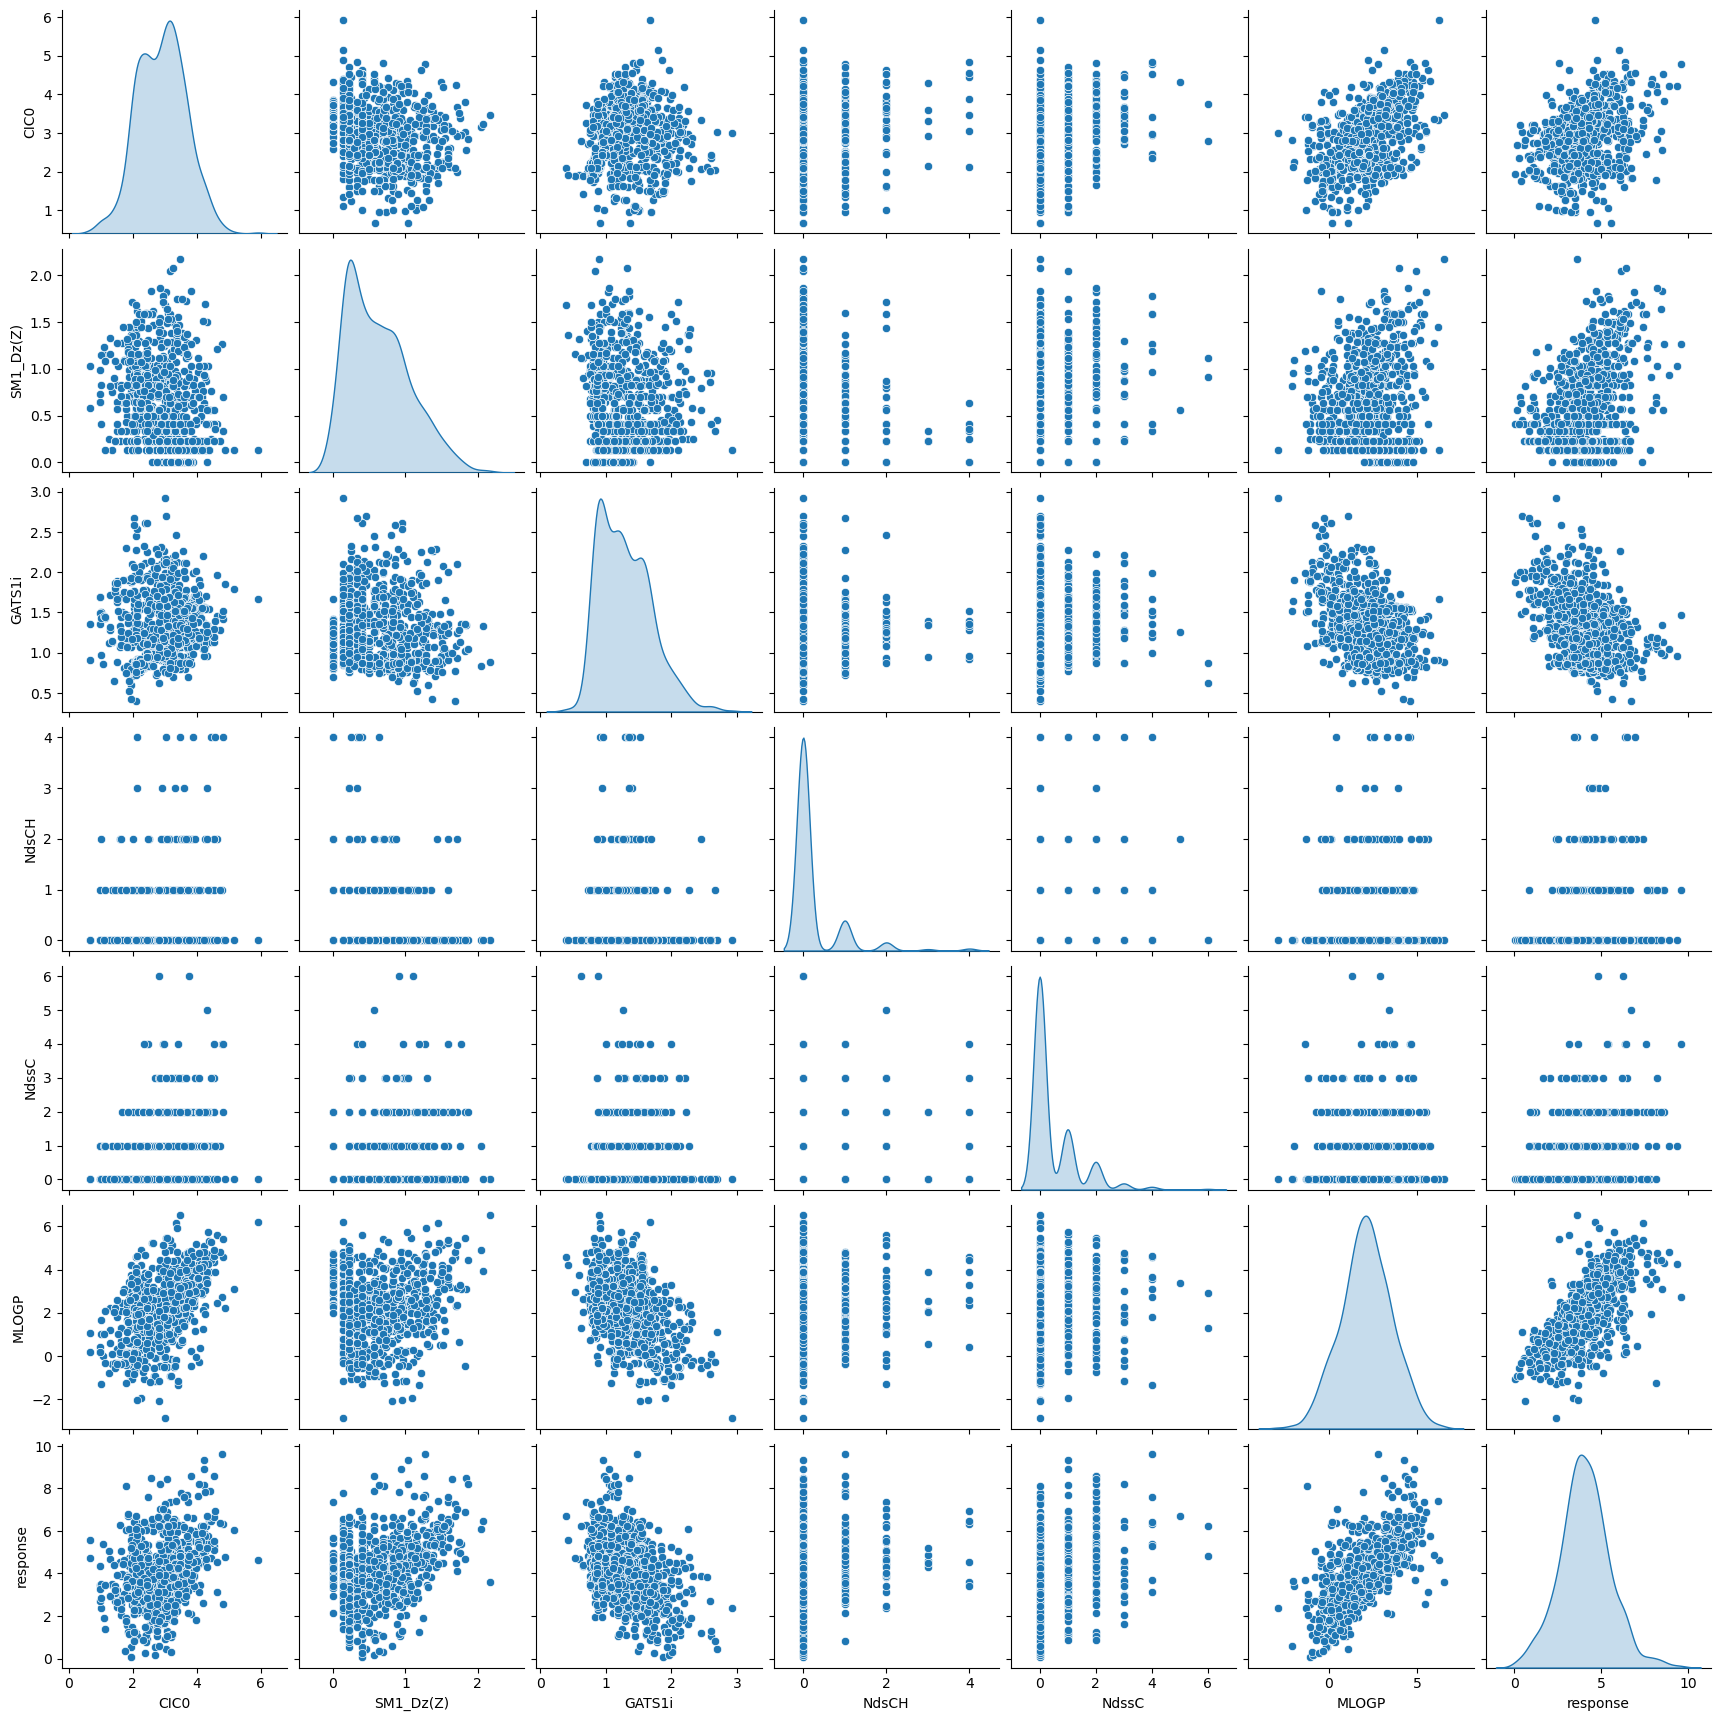

In [13]:
sns.pairplot(fishdata, diag_kind='kde');

### Handling outliers

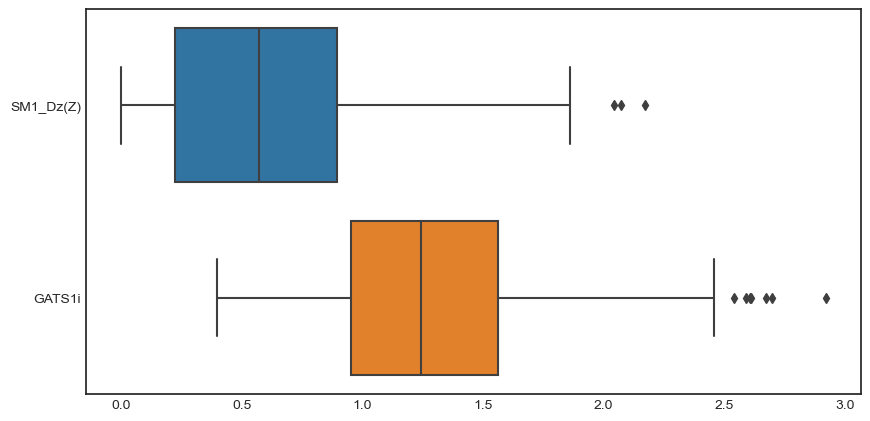

In [14]:
plt.style.use('seaborn-white')

plt.figure(figsize = (10,5))
sns.boxplot(data = fishdata[['SM1_Dz(Z)', 'GATS1i']], orient='h');

In [15]:
for col in ['SM1_Dz(Z)', 'GATS1i']:
    filter_val = fishdata[col].mean() + 3*fishdata[col].std()
    fishdata.loc[fishdata[col] > filter_val, col] = fishdata[col].median()

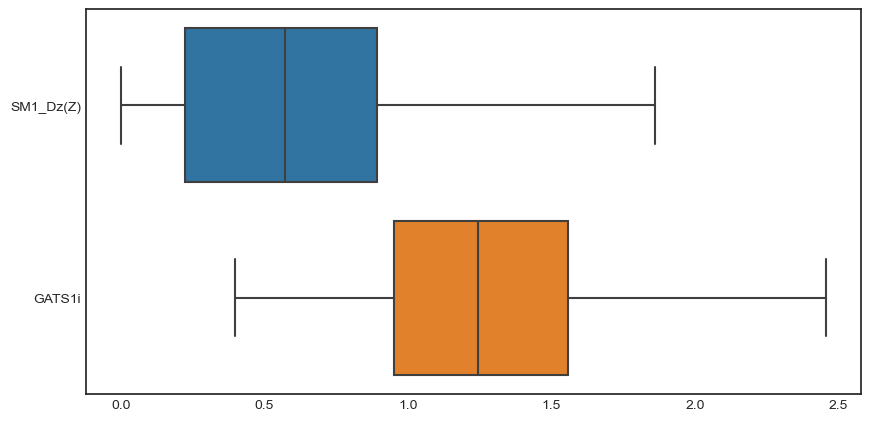

In [16]:
plt.style.use('seaborn-white')

plt.figure(figsize = (10,5))
sns.boxplot(data = fishdata[['SM1_Dz(Z)', 'GATS1i']], orient='h');

In [17]:
# getting correlation of the data columns with each other

corr = fishdata.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\Luvkush\AppData\Local\Temp\ipykernel_572\2584512324.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,response
CIC0,nan,nan,nan,nan,nan,nan,nan
SM1_Dz(Z),-0.25,nan,nan,nan,nan,nan,nan
GATS1i,0.17,-0.14,nan,nan,nan,nan,nan
NdsCH,0.12,-0.14,-0.01,nan,nan,nan,nan
NdssC,0.25,0.17,0.11,0.19,nan,nan,nan
MLOGP,0.46,0.18,-0.42,0.05,0.03,nan,nan
response,0.29,0.41,-0.37,0.17,0.17,0.65,nan


In [18]:
# This below function calculates the Variance Inflation Factor, which basically tells us if the numerical column present in 
# our data is adding to the value or not.

def get_VIF(input_df):
    
    cols = input_df.columns
    
    for col in cols:
        X = input_df.drop(col, axis = 1)
        y = input_df[col]
        
        r_sq = ols(formula = 'y ~ X', data = input_df).fit().rsquared
        vif = round( 1/(1-r_sq),2)
        print(f"{col} VIF: {vif}")

In [19]:
get_VIF(fishdata)

CIC0 VIF: 2.21
SM1_Dz(Z) VIF: 1.72
GATS1i VIF: 1.64
NdsCH VIF: 1.15
NdssC VIF: 1.24
MLOGP VIF: 2.62
response VIF: 2.38


### 4. Splitting of the dataset

In [20]:
# Splitting the data into features and target seperately

X = fishdata.drop('response', axis = 1)
y = fishdata['response']

In [21]:
# Splitting of training and test set into 80%-20% ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [22]:
X_train.shape, X_test.shape

((725, 6), (182, 6))

In [23]:
y_train.shape, y_test.shape

((725,), (182,))

### Standardizing the data

In [24]:
X_train.head(3)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP
341,4.037,0.134,1.563,0,0,3.806
241,3.542,1.380,1.264,0,0,1.971
613,2.512,0.134,0.862,0,0,1.506


In [25]:
X_test.head(3)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP
162,3.641,0.405,1.531,0,1,3.289
825,3.874,0.638,1.352,4,1,2.575
135,2.802,0.223,1.600,1,0,1.064


In [26]:
X_train.columns

Index(['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLOGP'], dtype='object')

In [27]:
# scaling input features (except the categorical columns)

cols_to_scale = ['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'MLOGP']

scaler_x = MinMaxScaler()

X_train[cols_to_scale] = scaler_x.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler_x.transform(X_test[cols_to_scale])

In [28]:
X_train.head(3)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP
341,0.640806,0.073064,0.566505,0,0,0.711778
241,0.546682,0.752454,0.421359,0,0,0.516544
613,0.350827,0.073064,0.226214,0,0,0.467071


In [29]:
X_test.head(3)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP
162,0.565507,0.220829,0.550971,0,1,0.656772
825,0.609812,0.347874,0.464078,4,1,0.580806
135,0.405971,0.121592,0.584466,1,0,0.420045


In [30]:
# scaling target variables
scaler_y = MinMaxScaler()

y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test  = scaler_y.transform(y_test.values.reshape(-1,1))

In [31]:
y_train[:3]

array([[0.52700107],
       [0.64482391],
       [0.30266809]])

In [32]:
y_test[:3]

array([[0.31376734],
       [0.46093917],
       [0.38239061]])

In [33]:
# Converting the shapes for the inputs and outputs 

feature_cols = list(X_train.columns)

X_train_scaled = X_train.values
X_test_scaled = X_test.values

y_train_scaled = y_train.flatten()
y_test_scaled = y_test.flatten()

### 6. Building Linear Regression Model

In [34]:
linear_regression_model = LinearRegression() 

In [35]:
linear_regression_model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [36]:
#Predictions will be scaled as scaled data was used in training

y_pred_train_scaled = linear_regression_model.predict(X_train_scaled)
y_pred_test_scaled = linear_regression_model.predict(X_test_scaled) 

In [40]:
# getting the predictions in original scale

y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1,1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1,1)).flatten()

In [54]:
actual_pred_df_train = pd.DataFrame({'actual_response': scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).flatten(),
                               'predicted_response': y_pred_train}).reset_index(drop=True)
actual_pred_df_train['error'] = actual_pred_df_train['actual_response'] - actual_pred_df_train['predicted_response']
actual_pred_df_train.head()

,actual_response,predicted_response,error
0,5.180,4.253093,0.926907
1,6.284,5.178584,1.105416
2,3.078,3.185683,-0.107683
3,5.395,3.544377,1.850623
4,1.749,2.651753,-0.902753


In [60]:
actual_pred_df_test = pd.DataFrame({'actual_response': scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten(),
                               'predicted_response': y_pred_test}).reset_index(drop=True)
actual_pred_df_test['error'] = actual_pred_df_test['actual_response'] - actual_pred_df_test['predicted_response']
actual_pred_df_test.head()

,actual_response,predicted_response,error
0,3.182,4.339210,-1.157210
1,4.561,6.151725,-1.590725
2,3.825,3.119153,0.705847
3,2.226,3.044219,-0.818219
4,8.571,6.080663,2.490337


In [48]:
# Defining function to return the MAPE (Mean Absolute Percent Error)

def get_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [55]:
# defining a single function to get all required metrics of regression, to avoid writing it again and again

def regression_metrics(actual, predicted):
    
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = get_mape(actual, predicted)
    r_squared = r2_score(actual, predicted)
    
    return round(mae,2), round(mse,2), round(rmse,2), round(mape,2), round(r_squared, 2)
    


In [50]:
any(fishdata['response'] == 0) # checking if any of the target is 0, because MAPE will fail otherwise

False

In [56]:
mae, mse, rmse, mape, r_squared = regression_metrics(actual_pred_df_train['actual_response'], 
                                                     actual_pred_df_train['predicted_response'])

In [58]:
print("Metrics for TRAIN Data\n")

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}%')
print(f'R Squared: {r_squared}')

Metrics for TRAIN Data

Mean Absolute Error: 0.7
Mean Squared Error: 0.89
Root Mean Squared Error: 0.94
Mean Absolute Percent Error: 24.6%
R Squared: 0.57


In [61]:
mae, mse, rmse, mape, r_squared = regression_metrics(actual_pred_df_test['actual_response'], 
                                                     actual_pred_df_test['predicted_response'])

In [63]:
print("Metrics for TEST Data\n")

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}%')
print(f'R Squared: {r_squared}')

Metrics for TEST Data

Mean Absolute Error: 0.66
Mean Squared Error: 0.88
Root Mean Squared Error: 0.94
Mean Absolute Percent Error: 43.47%
R Squared: 0.61


In [121]:
k_fold_cv = KFold(n_splits=10, random_state=101, shuffle=True)

r2_scores = cross_val_score(LinearRegression(), X_train_scaled, y_train_scaled, scoring='r2', cv=k_fold_cv)
r2_scores

array([0.30990822, 0.67582609, 0.50638467, 0.59245985, 0.58656934,
       0.55608903, 0.36870929, 0.76656349, 0.41597027, 0.65752277])

In [122]:
np.mean(r2_scores)

0.5436003027805532

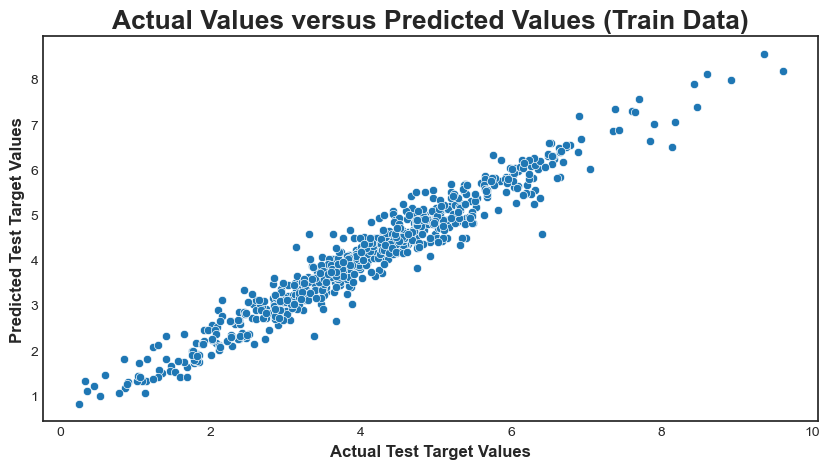

In [115]:
plt.style.use('seaborn-white')

plt.figure(figsize=(10,5))
sns.scatterplot(x=actual_pred_df_train['actual_response'],y=y_pred_train)
plt.title("Actual Values versus Predicted Values (Train Data)", fontdict = {'fontsize' : 19, 'weight': 'bold'})
plt.xlabel("Actual Test Target Values", fontdict = {'fontsize' : 12, 'weight': 'bold'})
plt.ylabel("Predicted Test Target Values", fontdict = {'fontsize' : 12, 'weight': 'bold'});

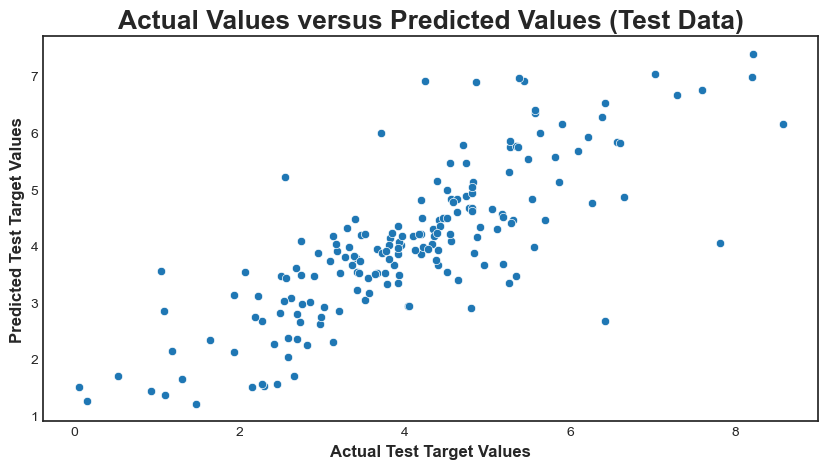

In [116]:
plt.style.use('seaborn-white')

plt.figure(figsize=(10,5))
sns.scatterplot(x=actual_pred_df_test['actual_response'],y=y_pred_test)
# plt.xlim(0,550000)
# plt.ylim(0, 700000)
plt.title("Actual Values versus Predicted Values (Test Data)", fontdict = {'fontsize' : 19, 'weight': 'bold'})
plt.xlabel("Actual Test Target Values", fontdict = {'fontsize' : 12, 'weight': 'bold'})
plt.ylabel("Predicted Test Target Values", fontdict = {'fontsize' : 12, 'weight': 'bold'});

### Further Analysis: OLS Regression from Statsmodel

##### Trying to build the linear regression model from OLS Regression (of Statsmodel library)

In [68]:
fishdata.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,response
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [71]:
fishdata.rename(columns={"SM1_Dz(Z)": "SM1_Dz_Z"}, inplace=True)

In [72]:
fishdata.head()

,CIC0,SM1_Dz_Z,GATS1i,NdsCH,NdssC,MLOGP,response
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [77]:
# getting all the input column names (features)

features = ' + '.join(fishdata.columns[:-1])
features

'CIC0 + SM1_Dz_Z + GATS1i + NdsCH + NdssC + MLOGP'

In [78]:
model = ols(formula = 'response ~ ' + features, data = fishdata).fit() # building the model

In [79]:
model.summary() # viewing the summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     207.6
Date:                Sun, 09 Apr 2023   Prob (F-statistic):          5.43e-166
Time:                        15:10:15   Log-Likelihood:                -1233.5
No. Observations:                 907   AIC:                             2481.
Df Residuals:                     900   BIC:                             2515.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0739      0.183     11.339      0.000       1.715       2.433
CIC0           0.3828      0.061      6.326      0.000       0.264       0.502
SM1_Dz_Z       1.3040      0.088     14.823      0.000       1.131       1.477
GATS1i        -0.7204      0.105     -6.892      0.000      -0.926      -0.515
NdsCH          0.4148      0.054      7.696      0.000       0.309       0.521
NdssC          0.0625      0.041      1.540      0.124      -0.017       0.142
MLOGP          0.4110      0.033     12.562      0.000       0.347       0.475
==============================================================================
Omnibus:                      102.230   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.912
Skew:                           0.523   Prob(JB):                     1.55e-74
Kurtosis:                       5.811   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Attempting to build Random Forest Regressor Model from Ensemble models library, to see how it performs

In [81]:
# instantiating and building the random forest regressor

random_forest_regressor = RandomForestRegressor(n_estimators = 150, random_state = 101)
random_forest_regressor.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor(n_estimators=150, random_state=101)

In [82]:
#Predictions will be scaled as scaled data was used in training

y_pred_train_scaled = random_forest_regressor.predict(X_train_scaled)
y_pred_test_scaled = random_forest_regressor.predict(X_test_scaled) 

In [83]:
# getting the predictions in original scale

y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1,1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1,1)).flatten()

In [84]:
actual_pred_df_train = pd.DataFrame({'actual_response': scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).flatten(),
                               'predicted_response': y_pred_train}).reset_index(drop=True)
actual_pred_df_train['error'] = actual_pred_df_train['actual_response'] - actual_pred_df_train['predicted_response']
actual_pred_df_train.head()

,actual_response,predicted_response,error
0,5.180,5.194660,-0.014660
1,6.284,5.807545,0.476455
2,3.078,3.040211,0.037789
3,5.395,4.485473,0.909527
4,1.749,1.981754,-0.232754


In [85]:
actual_pred_df_test = pd.DataFrame({'actual_response': scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten(),
                               'predicted_response': y_pred_test}).reset_index(drop=True)
actual_pred_df_test['error'] = actual_pred_df_test['actual_response'] - actual_pred_df_test['predicted_response']
actual_pred_df_test.head()

,actual_response,predicted_response,error
0,3.182,3.913750,-0.731750
1,4.561,4.833528,-0.272528
2,3.825,4.131202,-0.306202
3,2.226,3.114646,-0.888646
4,8.571,6.144031,2.426969


In [86]:
mae, mse, rmse, mape, r_squared = regression_metrics(actual_pred_df_train['actual_response'], 
                                                     actual_pred_df_train['predicted_response'])

In [87]:
print("Metrics for TRAIN Data\n")

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}%')
print(f'R Squared: {r_squared}')

Metrics for TRAIN Data

Mean Absolute Error: 0.26
Mean Squared Error: 0.13
Root Mean Squared Error: 0.36
Mean Absolute Percent Error: 8.83%
R Squared: 0.94


In [88]:
mae, mse, rmse, mape, r_squared = regression_metrics(actual_pred_df_test['actual_response'], 
                                                     actual_pred_df_test['predicted_response'])

In [89]:
print("Metrics for TEST Data\n")

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}%')
print(f'R Squared: {r_squared}')

Metrics for TEST Data

Mean Absolute Error: 0.66
Mean Squared Error: 0.84
Root Mean Squared Error: 0.92
Mean Absolute Percent Error: 38.67%
R Squared: 0.63


In [109]:
forest_params = [{
    
    'max_depth': list(range(2, 11, 2)),
    'n_estimators': list(range(50,400,50))
    
                 }]

In [110]:
regressor = GridSearchCV(estimator = RandomForestRegressor(),
                         param_grid = forest_params,
                         scoring=['','r2'],
                         n_jobs=-1,
                         cv=3,
                         verbose=3,
                         return_train_score=True)

In [111]:
regressor.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 6, 8, 10],
                          'n_estimators': [50, 100, 150, 200, 250, 300, 350]}],
             return_train_score=True, scoring='r2', verbose=3)

In [112]:
regressor.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=150)

In [114]:
regressor.best_score_

0.5978400517766084

<center> <h3> End of the Project </h3> </center>